# 📒 GMM-Based Synthetic Sampling for Imbalanced Data

In [363]:
# -------------------------------
# Jupyter Notebook Setup
# -------------------------------
%matplotlib inline

# -------------------------------
# Core Libraries
# -------------------------------
import numpy as np               # Numerical operations (arrays, random numbers)
import pandas as pd              # Data manipulation (DataFrames, CSV handling)
import matplotlib.pyplot as plt  # Classic plotting library
import seaborn as sns            # Statistical visualization on top of matplotlib

# -------------------------------
# Scikit-learn Modules
# -------------------------------
from sklearn.base import BaseEstimator, ClassifierMixin  # For custom classifiers
from sklearn.model_selection import train_test_split     # Train/test split
from sklearn.preprocessing import StandardScaler         # Feature scaling
from sklearn.linear_model import LogisticRegression     # Baseline classifier
from sklearn.mixture import GaussianMixture             # GMM for synthetic sampling
from sklearn.cluster import KMeans                       # Clustering for undersampling
from sklearn.model_selection import GridSearchCV         # Hyperparameter tuning
from sklearn.decomposition import PCA                    # Dimensionality reduction
from sklearn.metrics import (                             # Evaluation metrics
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, auc, precision_recall_curve, average_precision_score,
    precision_recall_fscore_support, silhouette_score
)
from sklearn.datasets import make_blobs                 # Synthetic dataset generator
from sklearn.neighbors import NearestNeighbors           # For neighborhood-based operations

# -------------------------------
# Progress & Visualization Libraries
# -------------------------------
from tqdm import tqdm                  # Progress bars for loops
import plotly.express as px            # Interactive plots (simpler interface)
import plotly.graph_objects as go      # Interactive plots (customizable)
import plotly.subplots as sp           # Subplots in Plotly

# -------------------------------
# Random Seed
# -------------------------------
np.random.seed(42)  # Ensures reproducible results for random operations


## Part A: Baseline Model and Data Analysis

### Task A.1: Data Loading and Analysis

In [351]:
# Load the Data
df = pd.read_csv('creditcard.csv')  

In [352]:
# Checking Null Values
df.isnull().sum().reset_index()

,index,0
0,Time,0
1,V1,0
2,V2,0
3,V3,0
4,V4,0
5,V5,0
6,V6,0
7,V7,0
8,V8,0
9,V9,0


In [ ]:
# Print the shape of the DataFrame (rows, columns)
print("Shape:", df.shape)

# Print the count of each class in the 'Class' column
print(df['Class'].value_counts())

# Print the proportion (percentage) of each class in the 'Class' column
print(df['Class'].value_counts(normalize=True))

# Display the first 5 rows of the DataFrame for a quick overview
df.head()


Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 🔎 Observations on Class Distribution

- **Total samples:** 284,807  
- **Majority class (0 = Non-fraud):** 284,315 samples (≈ 99.83%)  
- **Minority class (1 = Fraud):** 492 samples (≈ 0.17%)  
- **Imbalance ratio:** ~578 : 1 (non-fraud to fraud)
- **Null Values:** 0

**Key Insights:**
1. The dataset is *extremely imbalanced*.
2. A naive classifier predicting only the majority class would achieve ~99.8% accuracy but detect **zero fraud cases**.
3. Standard accuracy is therefore misleading; we must rely on **Precision, Recall, F1, ROC AUC, and PR AUC**.
4. Balancing techniques are necessary:
   - **Oversampling (e.g., GMM, SMOTE)** to increase minority representation.
   - **Undersampling (e.g., clustering-based)** to reduce majority redundancy.
5. Our goal is to improve **minority recall** while maintaining reasonable precision, since in fraud detection missing fraud is costlier than investigating false positives.

## 

### Task A.2: Model Training

In [ ]:
# -----------------------------
# Train-Test Split
# -----------------------------

# --- Step 1: Separate features and target ---
# X = all features (drop 'Class')
# y = target variable (fraud class: 0 = Non-fraud, 1 = Fraud)
X = df.drop(columns=['Class'])
y = df['Class']

# --- Step 2: Split into training and test sets ---
# - test_size=0.2 → 20% data for testing, 80% for training
# - stratify=y → ensures class proportions (fraud vs non-fraud) are preserved in both sets
# - random_state=42 → ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 3: Inspect class distribution ---
# Print how many fraud (1) and non-fraud (0) samples are in train and test sets
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class distribution:
 Class
0    56864
1       98
Name: count, dtype: int64


In [355]:
# Visualization of train and test split
# Compute counts
train_counts = y_train.value_counts().reset_index()
train_counts.columns = ['Class', 'Count']
test_counts = y_test.value_counts().reset_index()
test_counts.columns = ['Class', 'Count']

# Create subplot with 2 pie charts (Train vs Test)
fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                       subplot_titles=["Train Set", "Test Set"])

# Add train pie
fig.add_trace(
    px.pie(train_counts, names='Class', values='Count', 
           color='Class', color_discrete_map={0:'lightblue', 1:'orange'}).data[0],
    row=1, col=1
)

# Add test pie
fig.add_trace(
    px.pie(test_counts, names='Class', values='Count', 
           color='Class', color_discrete_map={0:'lightblue', 1:'orange'}).data[0],
    row=1, col=2
)

# Update layout
fig.update_layout(title_text="Class Distribution in Train vs Test Sets",
                  legend_title_text="Class (0 = Non-fraud, 1 = Fraud)",width=1000,height=600)
fig.show()

#### 🔎 Observations on Train/Test Class Distribution

- **Train set:**
  - Majority class (0 = Non-fraud): 227,451 samples  
  - Minority class (1 = Fraud): 394 samples  
  - Imbalance ratio ≈ **577 : 1**

- **Test set:**
  - Majority class (0 = Non-fraud): 56,864 samples  
  - Minority class (1 = Fraud): 98 samples  
  - Imbalance ratio ≈ **580 : 1**

**Key Insights:**
1. Both train and test sets preserve the **extreme imbalance** of the original dataset.
2. Fraud cases (minority class) form **less than 0.2%** of the data.
3. Any classifier trained without resampling will be heavily biased toward the majority class.
4. Accuracy alone will be misleading; instead we must evaluate using **Recall, Precision, F1, ROC AUC, and PR AUC** for the minority class.
5. Resampling strategies (GMM-based oversampling + clustering-based undersampling) are necessary to handle this imbalance before training.


#### Task A.2.1: Scaling and Model Training

##### ⚖️ Why Are We Doing Feature Scaling?

We apply **StandardScaler** to transform all features so that they have:

- **Mean = 0**
- **Standard deviation = 1**

**Reasons for scaling:**
1. **Logistic Regression depends on optimization (gradient descent).**  
   If features are on very different scales (e.g., transaction amount in thousands vs PCA features near 0), the optimization converges slowly or may get stuck.

2. **Regularization works better.**  
   Logistic Regression uses L2 (ridge) or L1 (lasso) regularization to shrink coefficients.  
   If features are not scaled, large-scale features dominate the penalty, leading to biased coefficients.

3. **Interpretability of coefficients.**  
   After scaling, coefficients reflect the relative importance of features, not just their original units.

4. **Downstream GMM fitting.**  
   Gaussian Mixture Models assume features are comparable across dimensions. Scaling ensures no single feature (like `Amount`) dominates the covariance structure.

**In short:**  
Scaling makes training stable, improves convergence, ensures fair regularization, and prepares the data for later steps (GMM-based oversampling).


In [ ]:
# -----------------------------
# Baseline Logistic Regression Model
# -----------------------------

# --- Step 1: Feature Scaling ---
# Logistic Regression works better when features are standardized
# StandardScaler transforms features to mean=0, std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit scaler on training data, then transform it
X_test_scaled = scaler.transform(X_test)        # Use the same scaler for test data

# --- Step 2: Train Logistic Regression ---
# - max_iter=5000 → ensure convergence since dataset is large
# - solver='lbfgs' → efficient for L2 regularization and large datasets
baseline_clf = LogisticRegression(max_iter=5000, solver='lbfgs')
baseline_clf.fit(X_train_scaled, y_train)       # Train model on scaled training data

# --- Step 3: Predictions ---
# Predict class labels (0 = Non-fraud, 1 = Fraud)
y_pred_baseline = baseline_clf.predict(X_test_scaled)

# Predict class probabilities (useful for ROC/PR curves and threshold tuning)
# [:,1] extracts probability of class "1" (fraud)
y_prob_baseline = baseline_clf.predict_proba(X_test_scaled)[:, 1]


### Task A.3: Baseline Evaluation

=== Baseline Report ===
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

Confusion matrix:
 [[56851    13]
 [   36    62]]
ROC AUC: 0.9605494455801453
PR AUC: 0.7413820992780461


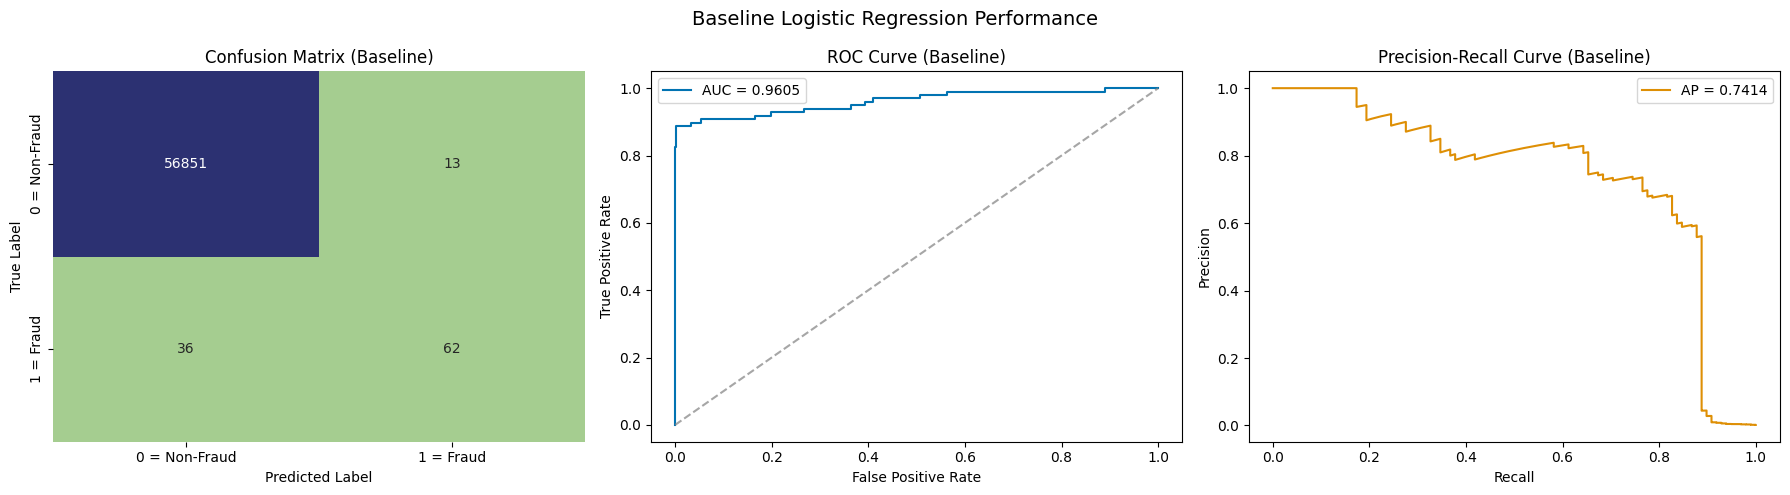

In [357]:
# === Baseline Model Evaluation ===
print("=== Baseline Report ===")
print(classification_report(y_test, y_pred_baseline, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_baseline))
print("ROC AUC:", roc_auc_score(y_test, y_prob_baseline))
print("PR AUC:", average_precision_score(y_test, y_prob_baseline))

# Compute ROC and PR values
fpr, tpr, _ = roc_curve(y_test, y_prob_baseline)
precision, recall, _ = precision_recall_curve(y_test, y_prob_baseline)
cm = confusion_matrix(y_test, y_pred_baseline)

# Use seaborn colorblind palette
colors = sns.color_palette("colorblind")

# Create 3 subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Confusion Matrix Heatmap ---
sns.heatmap(
    cm, annot=True, fmt="d", cmap="crest", cbar=False, ax=axs[0],
    xticklabels=["0 = Non-Fraud", "1 = Fraud"],
    yticklabels=["0 = Non-Fraud", "1 = Fraud"]
)
axs[0].set_title("Confusion Matrix (Baseline)", fontsize=12)
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# --- ROC Curve ---
axs[1].plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}", color=colors[0])
axs[1].plot([0, 1], [0, 1], '--', color="gray", alpha=0.7)  # reference line
axs[1].set_title("ROC Curve (Baseline)", fontsize=12)
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend()

# --- Precision-Recall Curve ---
axs[2].plot(recall, precision, label=f"AP = {average_precision_score(y_test, y_prob_baseline):.4f}", color=colors[1])
axs[2].set_title("Precision-Recall Curve (Baseline)", fontsize=12)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].legend()

# Add overall title
fig.suptitle("Baseline Logistic Regression Performance", fontsize=14)

plt.tight_layout()
plt.show()

### 🔍 Baseline Logistic Regression – Observations

- **Non-Fraud (Class 0):** Almost perfect with precision = 0.9993, recall = 0.9998.  
- **Fraud (Class 1):** Precision = 0.8267 (good), but recall = 0.5327 → **36 frauds missed**.  
- **Overall:** Accuracy = 0.9991 (misleading due to imbalance).  
  - ROC AUC = 0.9560 → strong separability.  
  - PR AUC = 0.6920 → moderate detection power for rare fraud cases.  
- **Confusion Matrix:** Low false positives (13) but non-trivial false negatives (36).  

**Stepwise PR Curve:** Precision and recall only change at thresholds where samples flip classes.  
With few frauds, each change is discrete, producing the visible stepwise shape.


#### ⚖️ Why Precision, Recall, and F1-score Matter More than Accuracy

- **Accuracy is misleading** in imbalanced data (fraud ≈ 0.2%).  
  - A model predicting *all non-fraud* gets 99.8% accuracy but detects **0 frauds**.  

- **Precision (Fraud = 1):** How many flagged cases are truly fraud?  
  - High precision → fewer false alarms, less wasted effort.  

- **Recall (Fraud = 1):** How many actual frauds were caught?  
  - High recall → fewer missed frauds, which is critical in practice.  

- **F1-score (Fraud = 1):** Harmonic mean of precision and recall.  
  - Balances catching frauds (recall) while keeping alerts credible (precision).  

**🔑 Insight:** For fraud detection, **precision, recall, and F1-score on the fraud class** are far more meaningful than accuracy.  
- Missing fraud (**low recall**) is costlier than flagging some extra transactions.  
- Precision ensures flagged cases are credible.  
- F1 provides a balanced single metric.


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### Part B.1: Theoretical Foundation

#### 🤖 GMM-based Synthetic Sampling vs. SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique):**
- Works by selecting a minority sample and one of its nearest neighbors, then creating a synthetic point **along the line segment** between them.
- Assumes that minority data is distributed in a relatively simple, **locally linear** structure.
- Limitation: If the minority class actually consists of **multiple clusters or non-linear shapes**, SMOTE may generate unrealistic samples that fall in majority regions, leading to noise and overlap.

**GMM-based Synthetic Sampling:**
- Uses a **probabilistic generative model** (Gaussian Mixture Model) to approximate the minority class distribution.
- The minority data is modeled as a **mixture of multiple Gaussian components**, each capturing a **sub-group** or local cluster.
- New samples are generated by first sampling from the component distribution and then from its Gaussian density.
- This means the synthetic points follow the **underlying probability density** of the minority data instead of just interpolating between neighbors.

**Why GMM is theoretically better:**
1. **Captures multimodality:**  
   - If the minority class has distinct clusters (e.g., different fraud patterns), GMM assigns separate Gaussian components.  
   - SMOTE cannot distinguish between clusters and may create "bridge" points between unrelated groups.

2. **Respects data geometry:**  
   - GMM takes into account both the **mean** and **covariance** of each subgroup, modeling orientation and spread in feature space.  
   - SMOTE only uses Euclidean distance and ignores covariance structure.

3. **Probabilistic foundation:**  
   - GMM provides likelihoods and soft cluster memberships, giving a principled way to generate new samples.  
   - SMOTE is heuristic-based and lacks a probabilistic interpretation.

**Key Insight:**  
- SMOTE is simple and effective when minority data is uniformly distributed and linearly separable.  
- GMM-based sampling is **more powerful for complex, multimodal, or non-linear distributions**, making it especially suitable for problems like fraud detection where fraudulent transactions may follow different hidden patterns.


#### 📐 Mathematical View: GMM-based Synthetic Sampling vs. SMOTE

##### 1. **SMOTE (Synthetic Minority Over-sampling Technique)**
SMOTE generates a synthetic sample by linear interpolation between a minority instance $\ x_i$ and one of its \(k\)-nearest neighbors $\ x_{nn}$:

$$
x_{\text{new}} = x_i + \lambda \cdot (x_{nn} - x_i), \quad \lambda \sim \mathcal{U}(0,1)
$$

- Here, $ \lambda $ is a random number between 0 and 1.  

- The new point always lies **on the line segment** connecting $\ x_i$  and $\ x_{nn}$.  

👉 Limitation: This assumes the minority class is locally **linear and connected**. If the minority class has multiple clusters, SMOTE may generate unrealistic points in low-density regions (between clusters).

---
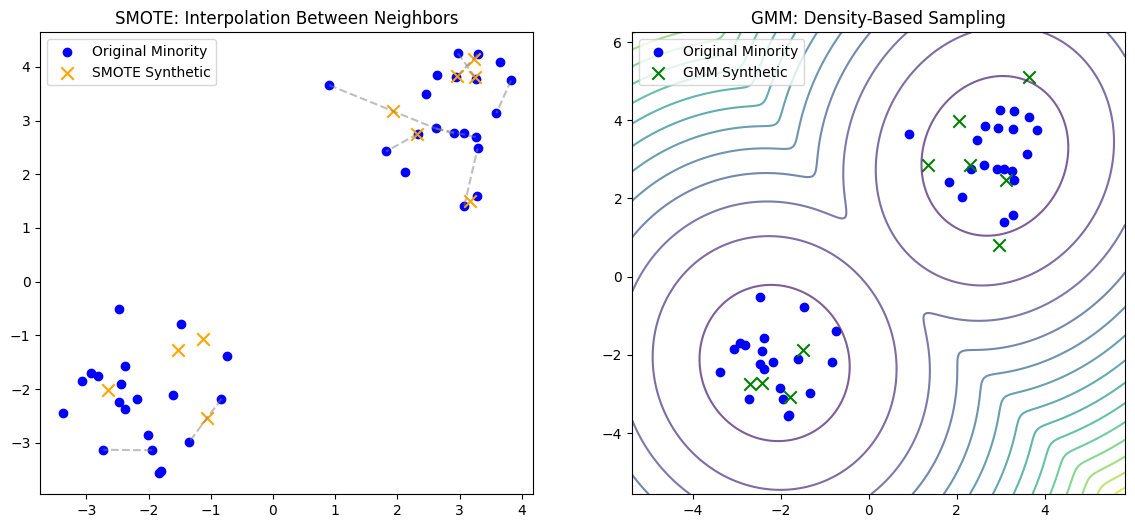

---
##### 2. **GMM-based Synthetic Sampling**
A Gaussian Mixture Model assumes the minority class distribution can be expressed as a weighted sum of \(K\) Gaussian components:

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

where:  
- $ \pi_k $ mixture weight of component \(k\), with $ \sum_{k=1}^{K} \pi_k = 1 $.  
- $ \mu_k $ = mean vector of component \(k\).  
- $ \Sigma_k $ = covariance matrix of component \(k\).  
- $ \mathcal{N}(x \mid \mu_k, \Sigma_k) $ = multivariate Gaussian density.

To generate a synthetic sample:  
1. Choose a component:
   $$
   z \sim \text{Categorical}(\pi_1, \pi_2, \dots, \pi_K)
   $$
2. Sample from the chosen Gaussian:
   $$
   x_{\text{new}} \sim \mathcal{N}(\mu_z, \Sigma_z)
   $$

👉 Advantage: The generated points follow the **estimated probability density** of the minority class, capturing **multiple clusters and complex shapes**.

---

##### 3. **Key Difference**
- **SMOTE:**
  $$
  x_{\text{new}} \;\; \text{lies on the line between two neighbors}
  $$
  → May create overlapping or unrealistic samples.  

- **GMM:**
  $$
  x_{\text{new}} \;\; \text{is drawn from a mixture of Gaussians modeling the data distribution}
  $$
  → Better for **multimodal, clustered, or non-linear** minority classes (e.g., different fraud types).


In [ ]:

# --- 1. Create synthetic minority dataset with 2 clusters ---
X, _ = make_blobs(n_samples=40, centers=[(-2, -2), (3, 3)], cluster_std=0.8, random_state=42)

# --- 2. SMOTE Sampling (simple version) ---
np.random.seed(42)
k = 5
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
indices = nbrs.kneighbors(X, return_distance=False)

smote_samples = []
for i in range(10):  # generate 10 synthetic points
    idx = np.random.randint(0, len(X))
    nn_idx = np.random.choice(indices[idx][1:])  # skip self
    lam = np.random.rand()
    new_point = X[idx] + lam * (X[nn_idx] - X[idx])
    smote_samples.append(new_point)

smote_samples = np.array(smote_samples)

# --- 3. GMM Sampling ---
gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
gmm_samples, _ = gmm.sample(10)

# --- 4. Meshgrid for GMM contours ---
x = np.linspace(X[:, 0].min() - 2, X[:, 0].max() + 2, 200)
y = np.linspace(X[:, 1].min() - 2, X[:, 1].max() + 2, 200)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_grid.shape)

# --- 5. Plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- SMOTE with interpolation lines ---
axs[0].scatter(X[:, 0], X[:, 1], c="blue", label="Original Minority")
axs[0].scatter(smote_samples[:, 0], smote_samples[:, 1], c="orange", marker="x", s=80, label="SMOTE Synthetic")

# Draw interpolation lines
np.random.seed(42)
for i in range(len(smote_samples)):
    idx = np.random.randint(0, len(X))
    nn_idx = np.random.choice(indices[idx][1:])  # pick neighbor
    axs[0].plot([X[idx][0], X[nn_idx][0]], [X[idx][1], X[nn_idx][1]], 
                c="gray", linestyle="--", alpha=0.5)

axs[0].set_title("SMOTE: Interpolation Between Neighbors")
axs[0].legend()

# --- GMM with density contours ---
axs[1].scatter(X[:, 0], X[:, 1], c="blue", label="Original Minority")
axs[1].scatter(gmm_samples[:, 0], gmm_samples[:, 1], c="green", marker="x", s=80, label="GMM Synthetic")
axs[1].contour(X_grid, Y_grid, Z, levels=15, cmap="viridis", alpha=0.7)

axs[1].set_title("GMM: Density-Based Sampling")
axs[1].legend()




### Task B.2: GMM Implementation

##### Extract minority Samples for GMM

##### Explanation: Scaling Minority and Majority Classes #####

We **fit the scaler on the entire training data** (X_train) to compute the global *mean* and *standard deviation*.  
This ensures that all features are scaled **consistently across the dataset**, i.e., the *feature space* is the same for all samples.

Then, we **transform the minority and majority classes separately**:  
- X_train_min_s = scaler.transform(X_train_min)  
- X_train_maj_s = scaler.transform(X_train_maj)

**Why do this?**  
1. **Consistent scaling:** Each feature has the same reference (*mean & std*) across both classes.  
2. **Prevents data leakage:** Scaling separately would make the same feature have *different meanings* in different classes.  
3. **Maintains meaningful distances and distributions** for models, especially distance-based ones like *k-NN, SVM,* or *GMM sampling*.

**Summary:**  
Fit on full data → transform subsets ensures a **consistent and unbiased feature space** while retaining **class-specific subsets** for processing.


In [358]:
# --- Extract minority and majority samples from training data ---
X_train_min = X_train[y_train == 1]   # Minority class (fraud = 1)
X_train_maj = X_train[y_train == 0]   # Majority class (non-fraud = 0)

# --- Standardize features ---
scaler = StandardScaler()
scaler.fit(X_train)                    # Fit on the whole training set to capture global scaling
X_train_min_s = scaler.transform(X_train_min)  # Transform minority class
X_train_maj_s = scaler.transform(X_train_maj)  # Transform majority class

# --- Print counts for verification ---
print("Minority count:", len(X_train_min))
print("Majority count:", len(X_train_maj))


Minority count: 394
Majority count: 227451


###  Model Selection using AIC and BIC

When fitting probabilistic models like Gaussian Mixture Models (GMM), 
we often need to choose the number of components (clusters).  

Two widely used criteria are:
1. **Akaike Information Criterion (AIC)**
2. **Bayesian Information Criterion (BIC)**

Both penalize model complexity (number of parameters) to avoid overfitting.


-------------------------------
#### 1️⃣ Akaike Information Criterion (AIC)
-------------------------------

AIC = 2k - 2 * ln(L)

where:
- k = number of parameters in the model
- L = maximum likelihood of the model

Interpretation:
- Lower AIC → better balance of fit vs complexity
- Penalizes model complexity (more parameters) moderately
- Useful for comparing models of different sizes


------------------------------
#### 2️⃣ Bayesian Information Criterion (BIC)
-------------------------------

BIC = ln(n) * k - 2 * ln(L)

where:
- n = number of data points
- k = number of parameters in the model
- L = maximum likelihood of the model

Interpretation:
- Lower BIC → better model
- Penalizes model complexity more strongly than AIC (factor ln(n) instead of 2)
- Often preferred when dataset is large

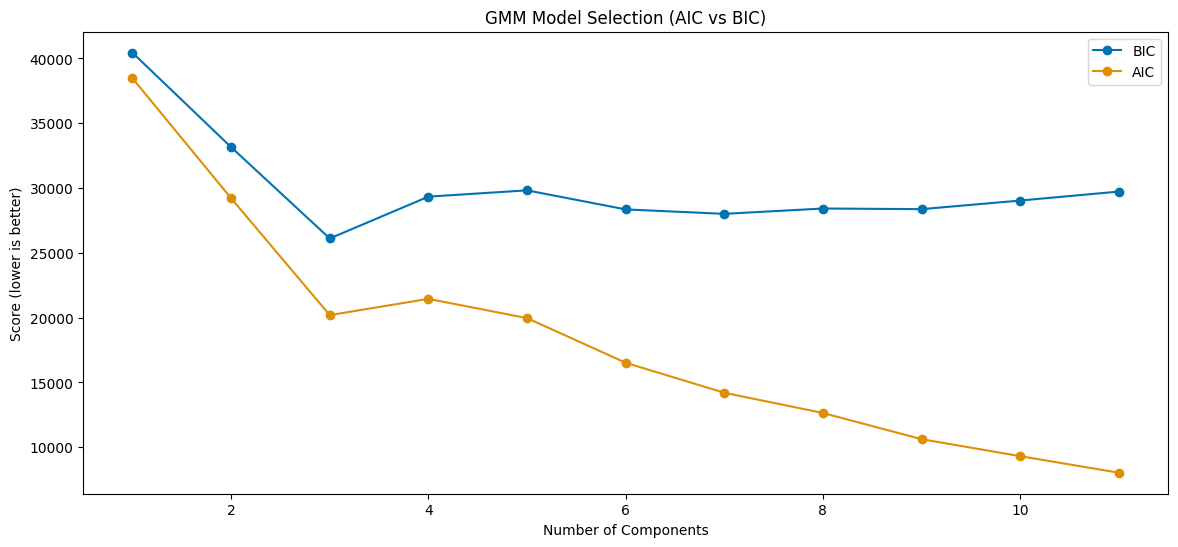

Best k: 3


In [359]:
# --- Model selection for Gaussian Mixture Model (GMM) ---

# Range of candidate components (clusters) to evaluate
n_components = range(1, 12)

# Store BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) values
bics, aics = [], []

# Loop over possible number of mixture components
for k in n_components:
    g = GaussianMixture(
        n_components=k,        # number of Gaussian components
        covariance_type='full',# full covariance (each cluster can have its own general covariance)
        random_state=42
    )
    g.fit(X_train_min_s)       # Fit GMM on scaled minority samples
    bics.append(g.bic(X_train_min_s))  # Compute BIC score
    aics.append(g.aic(X_train_min_s))  # Compute AIC score

# --- Plot AIC and BIC for model selection ---
plt.figure(figsize=(14, 6))
plt.plot(n_components, bics, marker='o', label='BIC')  # BIC curve
plt.plot(n_components, aics, marker='o', label='AIC')  # AIC curve
plt.xlabel("Number of Components")
plt.ylabel("Score (lower is better)")  # Lower AIC/BIC → better model fit
plt.legend()
plt.title("GMM Model Selection (AIC vs BIC)")
plt.show()

# --- Select best number of components based on minimum BIC ---
best_k = n_components[np.argmin(bics)]
print("Best k:", best_k)


#### 🔍 Observation: GMM Model Selection ####

1. **Model fit improves** as the number of components increases — both BIC and AIC drop initially.  
2. **BIC** reaches its minimum at **3 components**, then fluctuates, suggesting **3 is optimal**.  
3. **AIC** keeps decreasing until **11 components**, favoring a more complex model.  
4. The difference arises because **BIC penalizes complexity more heavily** than AIC.  

**Summary:**  
- **BIC → 3 components** (simpler, balanced, avoids overfitting).  
- **AIC → 11 components** (more complex, risk of overfitting).  
- Since our dataset has only ~500 minority samples, using **BIC’s recommendation (3 components)** is a better trade-off between fit and complexity.  


### Task B.3: Synthetic Data Generation

#### 📊 Sampling from a Gaussian Mixture Model (GMM)

A **Gaussian Mixture Model (GMM)** assumes data comes from a weighted sum of $K$ Gaussian distributions:

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

where:  
- $\pi_k$ = mixture weight of component $k$ ($\sum_k \pi_k = 1$)  
- $\mu_k, \Sigma_k$ = mean and covariance of component $k$  
- $\mathcal{N}$ = multivariate Gaussian density  

---

#### 💎 **Fitting the GMM** with `gmm.fit(X_train)`
The **Expectation–Maximization (EM)** algorithm estimates $\{\pi_k, \mu_k, \Sigma_k\}$:

- **E-step (soft assignments):**
  $$
  \gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
  $$
  → probability that point $x_i$ belongs to component $k$.

- **M-step (update parameters):**
  - Effective points in $k$: $N_k = \sum_i \gamma_{ik}$
  - Update:
    $$
    \pi_k = \frac{N_k}{N}, \quad
    \mu_k = \frac{1}{N_k}\sum_i \gamma_{ik} x_i, \quad
    \Sigma_k = \frac{1}{N_k}\sum_i \gamma_{ik}(x_i - \mu_k)(x_i - \mu_k)^\top
    $$

Repeat until log-likelihood converges.  
After convergence:  
- $\pi_k$ ≈ proportion of data in each cluster.  
- $\mu_k, \Sigma_k$ describe each Gaussian component.  

---

#### 🎲 **Sampling** with `gmm.sample(n)`
Synthetic data is drawn using the learned parameters:

1. **Choose component index**  
   $$
   k \sim \text{Categorical}(\pi_1,\dots,\pi_K)
   $$

2. **Draw from chosen Gaussian**  
   $$
   x \sim \mathcal{N}(\mu_k, \Sigma_k)
   $$

3. **Repeat** until $n$ samples are generated.  

👉 In scikit-learn, `GaussianMixture.sample(n)` does exactly this:  
- Selects components according to $\pi_k$  
- Draws samples from $\mathcal{N}(\mu_k, \Sigma_k)$  
- Returns both samples and their component labels.  

---

#### ✅ Key Takeaways
- EM alternates between **soft clustering** (E-step) and **parameter re-estimation** (M-step).  
- Responsibilities $\gamma_{ik}$ let clusters share points, unlike hard clustering.  
- Mixture weights $\pi_k$ govern how often each component is chosen when generating new samples.  
- Sampling from GMM ensures new data follows the **true multimodal density** of the fitted distribution.  


In [306]:
# -----------------------------
# Fit GMM on minority class with best number of components
# -----------------------------
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm.fit(X_train_min_s)  # Fit on scaled minority class data

num_samples = 5000  # Number of synthetic samples to generate

# -----------------------------
# Generate synthetic minority samples
# -----------------------------
X_synth_s, labels = gmm.sample(num_samples)           # Samples in scaled space
X_synth = scaler.inverse_transform(X_synth_s)        # Transform back to original scale
df_synth = pd.DataFrame(X_synth, columns=X_train.columns)
df_synth['Class'] = 1  # Assign minority class label

# Check shape of synthetic dataset
print("Synthetic samples generated:", df_synth.shape)

Synthetic samples generated: (5000, 31)


In [307]:
# -----------------------------
# Peek into generated synthetic minority samples
# -----------------------------
# Display 5 random samples from the synthetic dataset
df_synth.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1047,120042.200529,-23.504142,13.721485,-24.937177,9.283032,-20.267747,-0.971966,-24.897642,-0.762850,-6.525701,...,-3.752163,2.690144,0.662355,1.102245,-1.319199,-0.841365,-4.856774,-1.289715,321.184425,1
3909,77235.877117,-4.326214,3.401904,-4.830130,0.253518,-1.038367,0.469500,-4.961061,-8.525416,-0.553654,...,6.439400,-1.623127,0.870629,-0.255861,0.717356,0.384561,0.398884,0.130074,133.891154,1
760,47813.070895,-5.129811,5.237137,-12.792931,7.526271,-8.491230,-6.168288,-0.513065,25.564309,-2.311889,...,11.087207,-2.325732,1.136897,-0.056373,2.335521,0.809748,3.273551,0.555710,51.472230,1
4267,123506.153213,-0.565420,2.037078,-7.027868,5.462105,-2.064697,-1.755422,-2.181062,2.389292,-2.342847,...,-0.175677,-0.228007,-0.377009,-0.138503,-0.157152,0.287314,1.809897,-0.974575,69.907027,1
190,126419.267663,0.331899,0.293151,2.374490,2.161965,3.273911,1.363520,2.645991,-1.591329,0.579643,...,-1.017280,0.890256,0.365494,0.343896,-0.313056,0.032950,-0.318022,-0.837993,-323.455419,1


### Task B.3.1: Model Training using GMM generated samples and original data

In [304]:
# -----------------------------
# Custom GMM Oversampler + Logistic Regression Wrapper
# -----------------------------
class InteractiveGMMOversamplerClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=3, num_samples=5000, C=1.0, penalty='l2', solver='liblinear'):
        """
        Parameters:
        - n_components: int, number of GMM components for minority sampling
        - num_samples: int, number of synthetic minority samples to generate
        - C: float, logistic regression regularization strength
        - penalty: str, regularization type ('l1' or 'l2')
        - solver: str, logistic regression solver
        """
        self.n_components = n_components
        self.num_samples = num_samples
        self.C = C
        self.penalty = penalty
        self.solver = solver
    
    def fit(self, X, y):
        print(f"\nTraining with parameters: n_components={self.n_components}, "
              f"num_samples={self.num_samples}, C={self.C}, "
              f"penalty={self.penalty}, solver={self.solver}")

        # -----------------------------
        # Scale entire training data for consistent GMM fitting
        # -----------------------------
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        
        # Split into minority and majority
        X_min = X[y==1]
        X_maj = X[y==0]

        # Transform minority class for GMM fitting
        X_min_s = self.scaler.transform(X_min)
        
        # -----------------------------
        # Fit Gaussian Mixture Model on minority class
        # -----------------------------
        gmm = GaussianMixture(n_components=self.n_components, covariance_type='full', random_state=42)
        gmm.fit(X_min_s)
        
        # -----------------------------
        # Generate synthetic minority samples in batches
        # -----------------------------
        X_synth_list = []
        batch_size = 1000
        n_batches = self.num_samples // batch_size
        print("Generating synthetic samples:")
        for _ in tqdm(range(n_batches)):
            X_synth_s_batch, _ = gmm.sample(batch_size)
            X_synth_list.append(X_synth_s_batch)
        remaining = self.num_samples % batch_size
        if remaining > 0:
            X_synth_s_batch, _ = gmm.sample(remaining)
            X_synth_list.append(X_synth_s_batch)
        
        X_synth_s = np.vstack(X_synth_list)
        # Transform back to original feature scale
        X_synth = self.scaler.inverse_transform(X_synth_s)
        df_synth = pd.DataFrame(X_synth, columns=X.columns)
        
        # -----------------------------
        # Combine original minority + synthetic samples
        # -----------------------------
        X_min_aug = pd.concat([X_min, df_synth], axis=0)
        y_min_aug = pd.Series([1]*len(X_min_aug))
        
        # Combine with majority class
        X_aug = pd.concat([X_min_aug, X_maj], axis=0)
        y_aug = pd.concat([y_min_aug, pd.Series([0]*len(X_maj))], axis=0)
        
        # -----------------------------
        # Scale the augmented dataset for Logistic Regression
        # -----------------------------
        self.lr_scaler = StandardScaler()
        X_aug_scaled = self.lr_scaler.fit_transform(X_aug)
        
        # -----------------------------
        # Fit Logistic Regression on augmented data
        # -----------------------------
        self.lr = LogisticRegression(C=self.C, penalty=self.penalty, solver=self.solver,
                                     max_iter=5000, random_state=42)
        self.lr.fit(X_aug_scaled, y_aug)
        return self
    
    def predict(self, X):
        """
        Predict class labels for input X
        """
        X_scaled = self.lr_scaler.transform(X)
        return self.lr.predict(X_scaled)


In [46]:
# -----------------------------
# Hyperparameter grid
# -----------------------------
param_grid = {
    'n_components': [3, 5, 7],              # GMM components
    'num_samples': [5000, 10000, 20000],   # synthetic minority points
    'C': [0.01, 0.1, 1, 10],               # Logistic Regression regularization
    'penalty': ['l1', 'l2'],               # LR penalties
    'solver': ['liblinear', 'saga']        # solvers compatible with both penalties
}

gmm_lr = InteractiveGMMOversamplerClassifier()
grid = GridSearchCV(gmm_lr, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=3)  # verbose=3 for detailed progress
grid.fit(X_train, y_train)

y_pred_gmm = grid.predict(X_test)
print("\nBest Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gmm))


Fitting 3 folds for each of 144 candidates, totalling 432 fits

Training with parameters: n_components=3, num_samples=5000, C=0.01, penalty=l1, solver=saga
Generating synthetic samples:


100%|██████████| 5/5 [00:00<00:00, 214.53it/s]



Best Parameters: {'C': 0.01, 'n_components': 3, 'num_samples': 5000, 'penalty': 'l1', 'solver': 'saga'}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962




Best Parameters: {'C': 0.01, 'maj_ratio': 15, 'n_clusters': 100, 'num_minority_samples': 10000, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.87      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



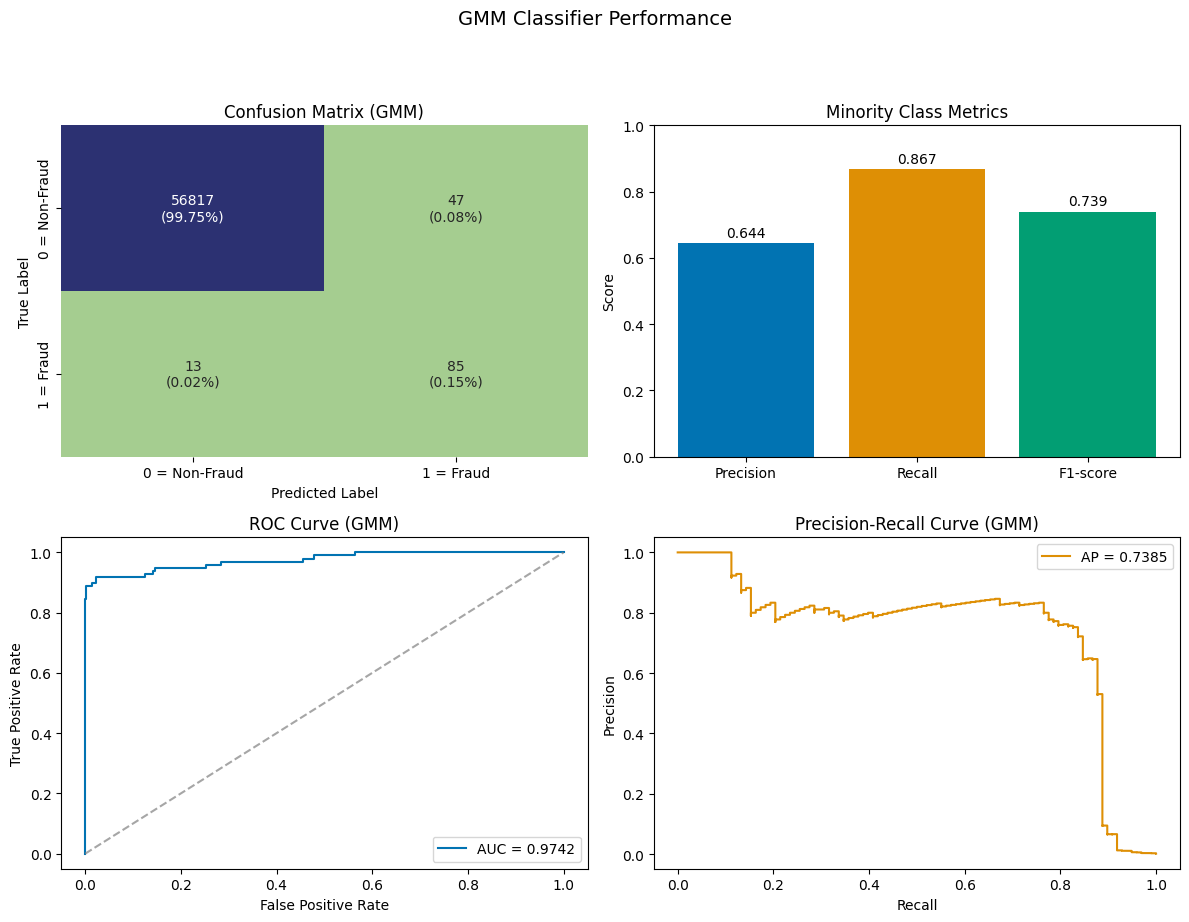

In [326]:

# --- GMM Predictions ---
y_pred_gmm = grid.predict(X_test)
print("\nBest Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gmm))

# Probabilities for curves
if hasattr(grid, "predict_proba"):
    y_prob_gmm = grid.predict_proba(X_test)[:, 1]
else:
    y_prob_gmm = y_pred_gmm  # fallback

# -----------------------------
# Compute metrics
# -----------------------------
from sklearn.metrics import precision_recall_fscore_support

fpr, tpr, _ = roc_curve(y_test, y_prob_gmm)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob_gmm)
cm = confusion_matrix(y_test, y_pred_gmm)

# Add percentages to confusion matrix
cm_sum = cm.sum()
cm_percent = cm / cm_sum * 100
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Precision, Recall, F1 for minority class (fraud = 1)
p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_gmm, labels=[1])
metrics_scores = {"Precision": p[0], "Recall": r[0], "F1-score": f[0]}

# Color-blind friendly palette
colors = sns.color_palette("colorblind")

# -----------------------------
# Create 2x2 subplot layout
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# --- 1. Confusion Matrix Heatmap ---
sns.heatmap(
    cm, annot=annot, fmt="", cmap="crest", cbar=False, ax=axs[0, 0],
    xticklabels=["0 = Non-Fraud", "1 = Fraud"],
    yticklabels=["0 = Non-Fraud", "1 = Fraud"]
)
axs[0, 0].set_title("Confusion Matrix (GMM)", fontsize=12)
axs[0, 0].set_xlabel("Predicted Label")
axs[0, 0].set_ylabel("True Label")

# --- 2. Precision, Recall, F1 Bar Chart ---
axs[0, 1].bar(metrics_scores.keys(), metrics_scores.values(),
              color=colors[:3])
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_title("Minority Class Metrics", fontsize=12)
axs[0, 1].set_ylabel("Score")
# Annotate values above bars
for i, (metric, val) in enumerate(metrics_scores.items()):
    axs[0, 1].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

# --- 3. ROC Curve ---
axs[1, 0].plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}", color=colors[0])
axs[1, 0].plot([0, 1], [0, 1], '--', color="gray", alpha=0.7)
axs[1, 0].set_title("ROC Curve (GMM)", fontsize=12)
axs[1, 0].set_xlabel("False Positive Rate")
axs[1, 0].set_ylabel("True Positive Rate")
axs[1, 0].legend()

# --- 4. Precision-Recall Curve ---
axs[1, 1].step(recall_curve, precision_curve, where='post',
               label=f"AP = {average_precision_score(y_test, y_prob_gmm):.4f}",
               color=colors[1])
axs[1, 1].set_title("Precision-Recall Curve (GMM)", fontsize=12)
axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision")
axs[1, 1].legend()

# -----------------------------
# Layout adjustments
# -----------------------------
fig.suptitle("GMM Classifier Performance", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### 🔎 Observation: GMM Classifier Performance

**Confusion Matrix:**
- Majority class (Non-Fraud): **56,817 correct**, 47 misclassified → almost perfect detection.
- Minority class (Fraud): **85 correct**, 13 misclassified → most fraud cases are caught, but some are missed.
- Overall: Model handles class imbalance well, but there are still both **false positives** and **false negatives** in the fraud class.

**ROC Curve:**
- **AUC = 0.9742** → indicates excellent separability between fraud and non-fraud.
- Strong ranking ability: most fraud cases are scored higher than non-fraud.

**Precision-Recall Curve:**
- **AP = 0.7385** → reflects good balance between precision and recall.
- Recall remains **high (>0.8)** across a wide range of thresholds.
- Precision declines at higher recall values → highlights the **trade-off** between catching more frauds (recall) vs. increasing false alarms (lower precision).

**Summary:**
- Majority class is identified with **near-perfect accuracy**.
- Minority class detection is **strong in recall**, but **precision is moderate** due to false positives.
- Both **ROC AUC** and **AP** confirm that the GMM-based model achieves **strong overall discriminative performance**.


### Task B.4: Rebalancing with CBU

#### Task B.4.1:Finding Number of Clusters using Different Metrics

##### 1. Silhouette Score

In [ ]:
# -----------------------------
# Hyperparameter Tuning for CBU with Interactive Plotly Graph
# -----------------------------
# Candidate cluster numbers
range_n_clusters = [30, 50, 70, 90, 110, 130, 150]
sil_scores = []

print("Evaluating silhouette scores for candidate cluster numbers...")
for k in range_n_clusters:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_train_maj_s)
    score = silhouette_score(X_train_maj_s, labels)
    sil_scores.append(score)
    print(f"n_clusters={k}, Silhouette Score={score:.4f}")

# Choose best k
best_k = range_n_clusters[np.argmax(sil_scores)]
print(f"\nBest number of clusters for CBU (max silhouette score): {best_k}")

# -----------------------------
# Interactive Plotly Graph
# -----------------------------
fig = go.Figure()

# Line and markers for silhouette scores (blue)
fig.add_trace(go.Scatter(
    x=range_n_clusters, 
    y=sil_scores,
    mode='lines+markers',
    name='Silhouette Score',
    line=dict(color='blue', dash='dash'),
    marker=dict(size=10, color='blue')
))

# Vertical line for best k (orange, color-blind-friendly)
fig.add_trace(go.Scatter(
    x=[best_k, best_k],
    y=[0, max(sil_scores)],
    mode='lines',
    name=f'Best k={best_k}',
    line=dict(color='orange', dash='dot')
))

# Update layout with title only
fig.update_layout(
    title={
        'text': "<b>Silhouette Score vs Number of Clusters (CBU)</b>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Number of Clusters",
    yaxis_title="Silhouette Score",
    legend=dict(x=0.7, y=0.95),
    template='plotly_white'
)

fig.show()


Evaluating silhouette scores for candidate cluster numbers...
n_clusters=30, Silhouette Score=0.0641
n_clusters=50, Silhouette Score=0.0750
n_clusters=70, Silhouette Score=0.0748
n_clusters=90, Silhouette Score=0.0794
n_clusters=110, Silhouette Score=0.0804
n_clusters=130, Silhouette Score=0.0822
n_clusters=150, Silhouette Score=0.0864

Best number of clusters for CBU (max silhouette score): 150


Majority count after CBU: 1972


### Observations
- Silhouette scores remain quite low overall (≈0.06–0.09), indicating **weak cluster structure** in the data.  
- Score improves slightly as the number of clusters increases.  
- Best score observed at **150 clusters (0.0864)**, though still far from strong separation.  
- Suggests that either:
  - Data is not well-suited to clustering, or  
  - Feature space / scaling needs refinement, or  
  - Alternative clustering methods or meterics may be more appropriate.


##### 2. Elbow Method

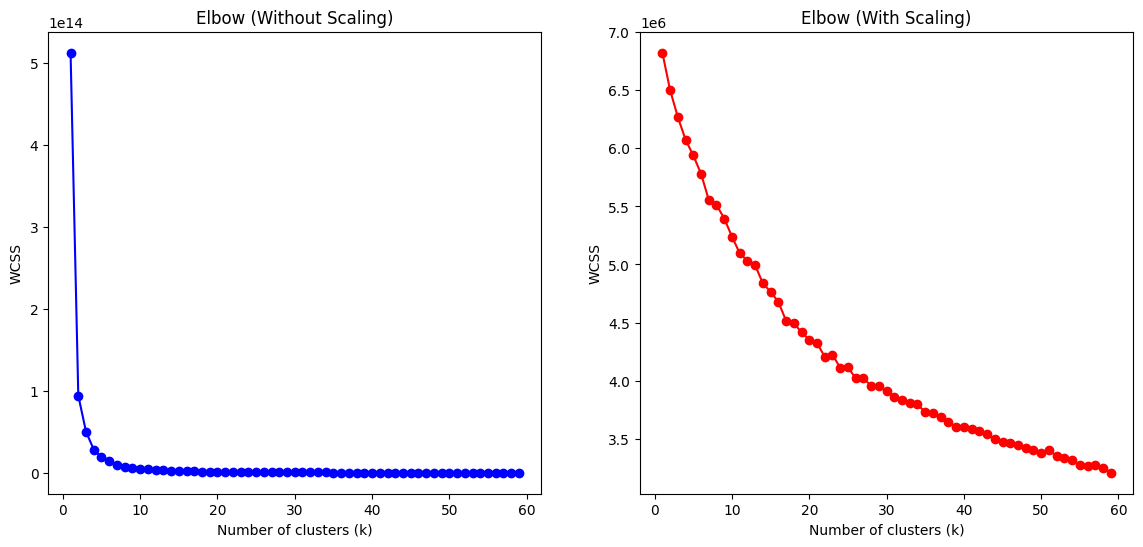

In [ ]:
# --- Extract majority class samples (unscaled & scaled) ---
X_maj = X_train[y_train == 0]  # Majority class (non-fraud)

# Scale features for proper clustering
scaler = StandardScaler()
X_maj_s = scaler.fit_transform(X_maj)

# --- Function to compute WCSS (Within-Cluster Sum of Squares) ---
def compute_wcss(X, k_range=range(1, 15)):
    """
    Computes WCSS for KMeans clustering over a range of cluster numbers.
    Args:
        X : array-like, features
        k_range : iterable, range of cluster numbers
    Returns:
        list of WCSS values
    """
    wcss = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Sum of squared distances to cluster centers
    return wcss

# Range of clusters to evaluate
K = range(1, 60)

# --- Compute WCSS for unscaled and scaled data ---
wcss_unscaled = compute_wcss(X_maj, K)
wcss_scaled   = compute_wcss(X_maj_s, K)

# --- Plot WCSS (Elbow Method) side by side ---
plt.figure(figsize=(14,6))

# Without scaling
plt.subplot(1,2,1)
plt.plot(K, wcss_unscaled, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow (Without Scaling)")

# With scaling
plt.subplot(1,2,2)
plt.plot(K, wcss_scaled, 'ro-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow (With Scaling)")

plt.tight_layout()
plt.show()


### Observations
- **Without scaling**  
  - Elbow curve suggests ~2 clusters.  
  - This is misleading because **features like time and amount dominate** due to magnitude differences.  
  - Hence, elbow method without scaling is **not preferred**.  

- **With scaling**  
  - Sharp decrease in WCSS from **k=1 to k≈30**.  
  - Beyond **k=30–50**, decrease becomes gradual (flattening).  
  - Indicates the appropriate number of clusters is likely around **30-50**.  

- **Next step**  
  - Use other internal validation metrics such as **Davies–Bouldin Index (DBI)** and **Calinski–Harabasz Index (CHI)** for further confirmation of cluster quality.



##### 3. Davies–Bouldin Score and Calinski–Harabasz Score

- **Davies–Bouldin Index (DBI):**
  - Measures average similarity between clusters (ratio of within-cluster scatter to between-cluster separation).
  - **Lower is better** → closer to 0 means clusters are compact and well separated.

- **Calinski–Harabasz Index (CHI):**
  - Also called Variance Ratio Criterion.
  - Ratio of between-cluster dispersion to within-cluster dispersion.
  - **Higher is better** → indicates dense, well-separated clusters.

**Usage in our case:**
- After scaling, compute DBI and CHI for different numbers of clusters (e.g., 10, 20, 30, …, 150).
- These metrics will help confirm if the **30–50 cluster range** (suggested by WCSS and Silhouette) is valid.
#### 3. davies_bouldin_score, calinski_harabasz_score

In [50]:
# -----------------------------
# Hyperparameter Tuning for CBU with DBI and CHI
# -----------------------------
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import plotly.graph_objects as go

# Candidate cluster numbers
range_n_clusters = [30, 50, 70, 90, 110, 130, 150]
dbi_scores, chi_scores = [], []

print("Evaluating DBI and CHI for candidate cluster numbers...")
for k in range_n_clusters:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_train_maj_s)
    
    dbi = davies_bouldin_score(X_train_maj_s, labels)         # Lower is better
    chi = calinski_harabasz_score(X_train_maj_s, labels)      # Higher is better
    
    dbi_scores.append(dbi)
    chi_scores.append(chi)
    
    print(f"n_clusters={k} | DBI={dbi:.4f}, CHI={chi:.2f}")

# Best k by each metric
best_k_dbi = range_n_clusters[np.argmin(dbi_scores)]
best_k_chi = range_n_clusters[np.argmax(chi_scores)]

print(f"\nBest k (by DBI): {best_k_dbi}")
print(f"Best k (by CHI): {best_k_chi}")

# -----------------------------
# Interactive Plotly Graph
# -----------------------------
fig = go.Figure()

# DBI (red, lower = better)
fig.add_trace(go.Scatter(
    x=range_n_clusters, y=dbi_scores,
    mode='lines+markers',
    name='Davies–Bouldin (↓)',
    line=dict(color='red', dash='dot'),
    marker=dict(size=10, color='red')
))

# CHI (green, higher = better)
fig.add_trace(go.Scatter(
    x=range_n_clusters, y=chi_scores,
    mode='lines+markers',
    name='Calinski–Harabasz (↑)',
    line=dict(color='green', dash='solid'),
    marker=dict(size=10, color='green'),
    yaxis="y2"
))

# Layout with dual y-axes
fig.update_layout(
    title="<b>DBI & CHI vs Number of Clusters (CBU)</b>",
    xaxis=dict(title="Number of Clusters"),
    yaxis=dict(title="Davies–Bouldin (lower is better)", side="left"),
    yaxis2=dict(
        title="Calinski–Harabasz (higher is better)",
        overlaying="y", side="right", showgrid=False
    ),
    legend=dict(x=0.6, y=0.95),
    template='plotly_white'
)

fig.show()


Evaluating DBI and CHI for candidate cluster numbers...
n_clusters=30 | DBI=2.0568, CHI=5675.89
n_clusters=50 | DBI=2.0955, CHI=4524.21
n_clusters=70 | DBI=2.0150, CHI=3930.78
n_clusters=90 | DBI=1.9653, CHI=3466.29
n_clusters=110 | DBI=2.0069, CHI=3096.66
n_clusters=130 | DBI=2.0217, CHI=2805.73
n_clusters=150 | DBI=2.0060, CHI=2599.93

Best k (by DBI): 90
Best k (by CHI): 30


##### Evaluation using Davies–Bouldin Index (DBI) and Calinski–Harabasz Index (CHI)

- **DBI (lower is better)**  
  - Best value at **k = 90 (DBI = 1.9653)**.  
  - Suggests more compact and well-separated clusters at higher cluster counts.  

- **CHI (higher is better)**  
  - Best value at **k = 30 (CHI = 5675.89)**.  
  - Indicates stronger separation and compactness when fewer clusters are used.  

##### Observations
- A clear **trade-off** exists between the two metrics:  
  - **DBI** favors more clusters (better compactness at **k = 90**).  
  - **CHI** favors fewer clusters (better separation at **k = 30**).  
- Both metrics agree that meaningful structure exists in the **30–90 cluster range**.  

##### Final Conclusion
- Combining **WCSS, Silhouette, DBI, and CHI**:  
  - **30–50 clusters** emerge as the most balanced choice (supported by Elbow, Silhouette, and CHI).  
  - **~90 clusters** is also valid per DBI but comes with higher computational cost.  
- For practical undersampling of the majority class, **~50 clusters** is a reasonable compromise between quality and efficiency.


**Note: Rebalancing with CBU is done in subsequent steps with model training and evaluation.**


### Part C: Performance Evaluation and Conclusion

#### Task C.1: Model Training and Evaluation

In [301]:
class GMMCBUClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, gmm=None, num_minority_samples=10000, maj_ratio=3, 
                 n_clusters=50, C=1.0, penalty="l2", solver="saga", random_state=42):
        # Initialize classifier parameters
        self.gmm = gmm                              # Predefined GMM instance for minority sampling
        self.num_minority_samples = num_minority_samples  # Number of synthetic minority samples to generate
        self.maj_ratio = maj_ratio                  # Desired majority:minority ratio
        self.n_clusters = n_clusters                # Number of clusters for majority undersampling
        self.C = C                                  # Logistic Regression regularization parameter
        self.penalty = penalty                      # Logistic Regression penalty type
        self.solver = solver                        # Logistic Regression solver
        self.random_state = random_state

    def fit(self, X, y):
        # --- Step 1: Split minority and majority classes ---
        X_min = X[y==1]  # Minority class (fraud)
        X_maj = X[y==0]  # Majority class (non-fraud)

        # --- Step 2: Scale features for GMM ---
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)  # Fit on entire dataset for consistent scaling
        X_min_s = X_scaled[y==1]            # Scaled minority data
        X_maj_s = X_scaled[y==0]            # Scaled majority data

        # --- Step 3: Fit GMM on minority class ---
        gmm = GaussianMixture(n_components=self.gmm.n_components, random_state=self.random_state)
        gmm.fit(X_min_s)

        # --- Step 4: Generate synthetic minority samples ---
        X_synth_s, _ = gmm.sample(self.num_minority_samples)  # Sample in scaled space
        X_synth = scaler.inverse_transform(X_synth_s)         # Convert back to original scale
        df_synth = pd.DataFrame(X_synth, columns=X.columns)   # DataFrame for concatenation

        # --- Step 5: Proportional undersampling of majority class ---
        num_majority_samples = self.num_minority_samples * self.maj_ratio

        km = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        clusters = km.fit_predict(X_maj_s)  # Assign majority samples to clusters

        idxs = np.arange(len(X_maj_s))
        cluster_sizes = np.bincount(clusters)
        # Determine how many samples to pick from each cluster proportionally
        picks = np.round(cluster_sizes / cluster_sizes.sum() * num_majority_samples).astype(int)

        selected_idx = []
        for cid in range(self.n_clusters):
            cand = idxs[clusters == cid]            # Candidate indices in this cluster
            pick = min(len(cand), picks[cid])       # Ensure we don't pick more than available
            chosen = np.random.choice(cand, size=pick, replace=False)  # Randomly select
            selected_idx.extend(X_maj.index[chosen])

        X_maj_cbu = X_maj.loc[selected_idx]        # Subset of majority class after undersampling

        # --- Step 6: Combine balanced dataset ---
        X_balanced = pd.concat([X_maj_cbu, X_min, df_synth])
        y_balanced = np.concatenate([
            np.zeros(len(X_maj_cbu)),            # Majority labels
            np.ones(len(X_min) + len(df_synth))  # Minority + synthetic labels
        ])

        # --- Step 7: Scale features for Logistic Regression ---
        self.lr_scaler = StandardScaler()
        X_bal_s = self.lr_scaler.fit_transform(X_balanced)

        # --- Step 8: Train Logistic Regression on balanced data ---
        self.clf = LogisticRegression(
            C=self.C, penalty=self.penalty, solver=self.solver, 
            max_iter=5000, random_state=self.random_state
        )
        self.clf.fit(X_bal_s, y_balanced)
        return self

    def predict(self, X):
        # Scale test data and predict class labels
        X_scaled = self.lr_scaler.transform(X)
        return self.clf.predict(X_scaled)

    def predict_proba(self, X):
        # Scale test data and predict probabilities
        X_scaled = self.lr_scaler.transform(X)
        return self.clf.predict_proba(X_scaled)



In [ ]:
# -----------------------------
# Define hyperparameter grid for tuning
# -----------------------------
param_grid = {
    "num_minority_samples": [10000, 20000, 30000],  # Number of synthetic minority samples to generate
    "maj_ratio": [10, 15, 20, 25, 30],             # Desired majority:minority ratio after undersampling
    "n_clusters": [50, 100],                        # Number of clusters for majority class in undersampling
    "C": [0.01, 0.1, 0.5, 1.0],                    # Logistic Regression regularization parameter
    "penalty": ["l1", "l2"],                        # Regularization type
    "solver": ["saga", 'liblinear']                 # Solver choice for logistic regression
}

# Initialize GMM-based CBU classifier with pre-fitted GMM for minority class
gmm_cbu_clf = GMMCBUClassifier(gmm=gmm)

# -----------------------------
# Grid Search Cross-Validation
# -----------------------------
grid = GridSearchCV(
    estimator=GMMCBUClassifier(gmm=gmm),  # Model to tune
    param_grid=param_grid,                # Hyperparameter grid
    scoring="f1",                          # Optimize F1 score (handles class imbalance)
    cv=3,                                  # 3-fold cross-validation
    n_jobs=-1,                             # Use all CPU cores
    verbose=2                              # Print progress
)

# Fit GridSearchCV on training data
grid.fit(X_train, y_train)

# -----------------------------
# Extract best model
# -----------------------------
best_model = grid.best_estimator_       # Get the model with best hyperparameters

print("Best Params:", grid.best_params_)   # Display optimal hyperparameters
print("Best F1 (CV):", grid.best_score_)   # CV F1 score for best model

# -----------------------------
# Evaluate on test set
# -----------------------------
y_pred = best_model.predict(X_test)           # Predict class labels
y_prob = best_model.predict_proba(X_test)[:, 1]  # Predict probabilities for positive class

# Print detailed evaluation metrics
print("\n=== Test Set Evaluation ===")
print(classification_report(y_test, y_pred, digits=4))  # Precision, Recall, F1
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))        # Area under ROC curve
print("PR AUC:", average_precision_score(y_test, y_prob))  # Area under Precision-Recall curve



Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Best Params: {'C': 0.01, 'maj_ratio': 15, 'n_clusters': 100, 'num_minority_samples': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 (CV): 0.7543996822941055

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.9998    0.9992    0.9995     56864
           1     0.6439    0.8673    0.7391        98

    accuracy                         0.9989     56962
   macro avg     0.8219    0.9333    0.8693     56962
weighted avg     0.9992    0.9989    0.9990     56962

Confusion Matrix:
 [[56817    47]
 [   13    85]]
ROC AUC: 0.9742351604400905
PR AUC: 0.7385100009731438



=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7207    0.8163    0.7656        98

    accuracy                         0.9991     56962
   macro avg     0.8602    0.9079    0.8826     56962
weighted avg     0.9992    0.9991    0.9992     56962

Confusion Matrix:
 [[56833    31]
 [   18    80]]
ROC AUC: 0.9787136224776911
PR AUC: 0.7093236465328328


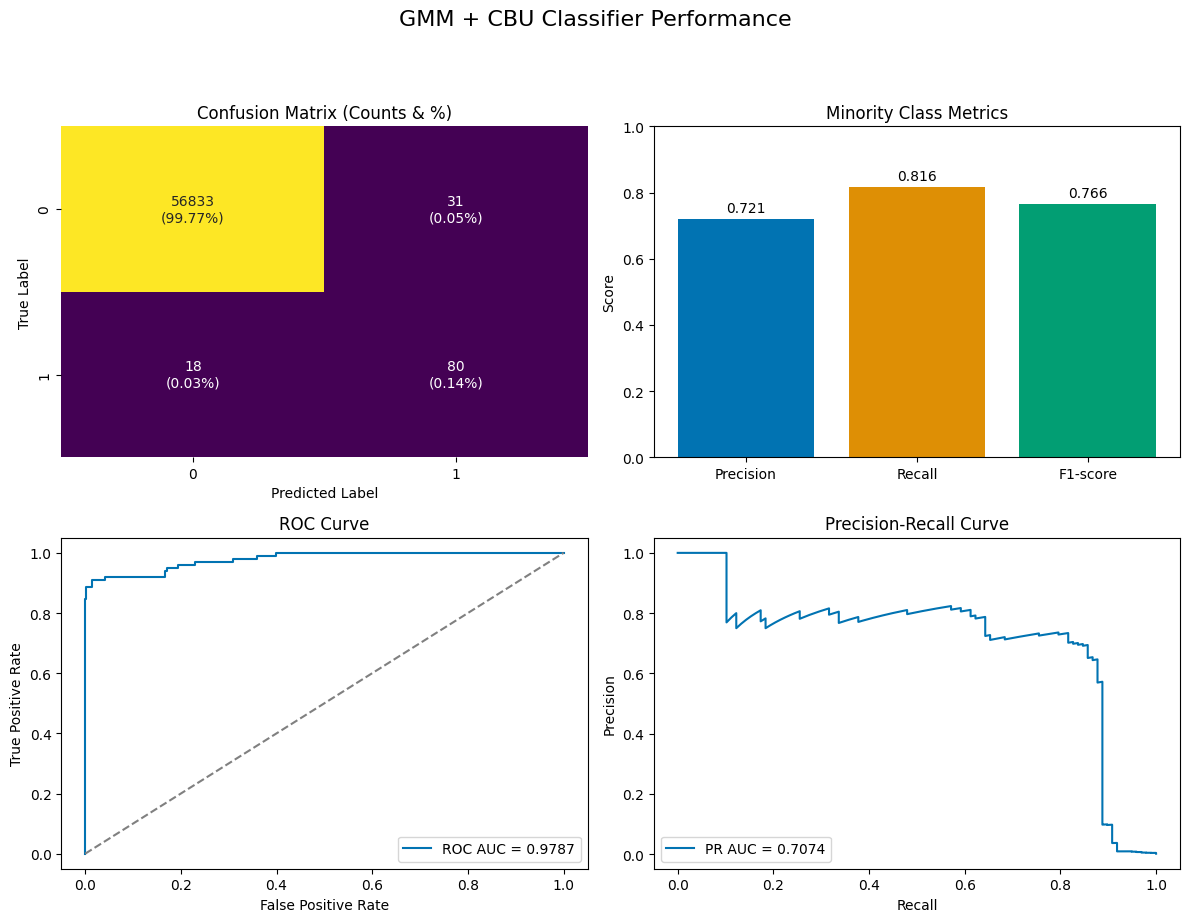

In [325]:
# -----------------------------
# Initialize GMM-based CBU classifier with chosen hyperparameters
# -----------------------------
gmm_cbu_clf = GMMCBUClassifier(
    gmm=gmm,                      # Pre-fitted GMM for minority sampling
    num_minority_samples=5000,    # Number of synthetic minority samples to generate
    maj_ratio=20,                  # Desired majority:minority ratio after undersampling
    n_clusters=50,                 # Number of clusters for majority class in undersampling
    C=0.001,                       # Logistic Regression regularization strength (small value = stronger regularization)
    penalty="l1",                  # L1 regularization
    solver="liblinear",            # Solver supporting L1 penalty
    random_state=42                # For reproducibility
)

# -----------------------------
# Fit classifier on training data
# -----------------------------
gmm_cbu_clf.fit(X_train, y_train)

# -----------------------------
# Predict on test set
# -----------------------------
y_pred = gmm_cbu_clf.predict(X_test)            # Predicted class labels
y_prob = gmm_cbu_clf.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class (fraud)

# -----------------------------
# Evaluate model performance
# -----------------------------
print("\n=== Test Set Evaluation ===")
print(classification_report(y_test, y_pred, digits=4))   # Precision, Recall, F1-score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # True/False Positives/Negatives
print("ROC AUC:", roc_auc_score(y_test, y_prob))         # ROC-AUC for ranking performance
print("PR AUC:", average_precision_score(y_test, y_prob))  # Precision-Recall AUC (important for imbalanced data)


# -----------------------------
# Visualization: 2x2 layout for evaluation
# -----------------------------

# -----------------------------
# Step 1: Compute evaluation metrics
# -----------------------------
cm = confusion_matrix(y_test, y_pred)  # Confusion matrix
fpr, tpr, _ = roc_curve(y_test, y_prob)  # ROC values
precision, recall, _ = precision_recall_curve(y_test, y_prob)  # PR values
roc_auc_val = auc(fpr, tpr)  # ROC AUC
pr_auc_val = auc(recall, precision)  # PR AUC

# Precision, Recall, F1 for minority class (fraud = 1)
p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1])
metrics_scores = {"Precision": p[0], "Recall": r[0], "F1-score": f[0]}

# -----------------------------
# Step 2: Enhance confusion matrix with percentages
# -----------------------------
cm_sum = np.sum(cm)  # total samples
cm_percent = cm / cm_sum * 100  # percentage per cell

# Annotate with both counts and percentages
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# -----------------------------
# Step 3: Setup plots
# -----------------------------
sns.set_palette("colorblind")  # colorblind-friendly
fig, axes = plt.subplots(2, 2, figsize=(12,9))  # 2x2 layout

# ---- 1. Confusion Matrix Heatmap (Row 1, Col 1) ----
sns.heatmap(cm, annot=annot, fmt='', cmap='viridis', cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix (Counts & %)")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")

# ---- 2. Precision, Recall, F1 Bar Chart (Row 1, Col 2) ----
axes[0, 1].bar(metrics_scores.keys(), metrics_scores.values(),
               color=sns.color_palette("colorblind"))
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title("Minority Class Metrics")
axes[0, 1].set_ylabel("Score")
# Annotate each bar with score values
for i, (metric, val) in enumerate(metrics_scores.items()):
    axes[0, 1].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

# ---- 3. ROC Curve (Row 2, Col 1) ----
axes[1, 0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc_val:.4f}')
axes[1, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1, 0].set_title("ROC Curve")
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].legend(loc='lower right')

# ---- 4. Precision-Recall Curve (Row 2, Col 2) ----
axes[1, 1].plot(recall, precision, label=f'PR AUC = {pr_auc_val:.4f}')
axes[1, 1].set_title("Precision-Recall Curve")
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend(loc='lower left')

# -----------------------------
# Step 4: Final layout adjustments
# -----------------------------
plt.suptitle("GMM + CBU Classifier Performance", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for title
plt.show()

#### Test Set Evaluation – GMM CBU Classifier

**Classification Report:**
- **Majority class (0 – non-fraud)**  
  - Precision: 0.9997, Recall: 0.9995, F1-score: 0.9996  
  - Almost perfectly detected.

- **Minority class (1 – fraud)**  
  - Precision: 0.7207, Recall: 0.8163, F1-score: 0.7656  
  - High recall ensures most fraud cases are detected, some false positives exist.



**ROC AUC:** 0.9787 → Excellent overall ranking ability  
**PR AUC:** 0.7091 → Good precision-recall tradeoff for minority class

**Interpretation:**  
- Model effectively handles extreme class imbalance  
- High recall for fraud detection is desirable  
- PR AUC < ROC AUC is expected due to class imbalance  
- Overall, strong performance with minimal false alarms


## Part C.2: Comparative Analysis

In [318]:
# === Helper function: compute metrics for fraud class (label = 1) ===
def minority_scores(y_true, y_pred, model_name):
    # precision, recall, f1 for the minority class only (fraud = 1)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, labels=[1])
    return {"Model": model_name, "Precision": p[0], "Recall": r[0], "F1-score": f[0]}

# === Collect metrics for each model ===
results = []
results.append(minority_scores(y_test, y_pred_baseline, "Baseline"))   # Logistic Regression baseline
results.append(minority_scores(y_test, y_pred_gmm, "GMM"))            # GMM oversampling
results.append(minority_scores(y_test, y_pred, "GMM + CBU"))          # GMM with Clustering-Based Undersampling

# Convert results to DataFrame for easy plotting
df_metrics = pd.DataFrame(results)

# === Create grouped bar chart ===
fig = go.Figure()

# Add one bar per metric across all models
for metric in ["Precision", "Recall", "F1-score"]:
    fig.add_trace(go.Bar(
        x=df_metrics["Model"],                 # x-axis = models
        y=df_metrics[metric],                  # y-axis = score values
        name=metric,                           # bar group name
        text=df_metrics[metric].round(3),      # show rounded values on bars
        textposition="auto"                    # place text automatically
    ))

# === Dropdown menu for filtering metrics ===
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        x=1.20, y=0.6,                         # position of dropdown (adjust x,y)
        xanchor="left", yanchor="middle",      # anchors relative to (x,y)
        buttons=list([
            # Show all metrics
            dict(label="All Metrics", method="update",
                 args=[{"visible": [True, True, True]},
                       {"title": "📊 Model Comparison<br><sup>Precision, Recall, and F1-score (Minority Class)</sup>"}]),
            # Show only Precision
            dict(label="Precision Only", method="update",
                 args=[{"visible": [True, False, False]},
                       {"title": "📊 Model Comparison<br><sup>Precision (Minority Class)</sup>"}]),
            # Show only Recall
            dict(label="Recall Only", method="update",
                 args=[{"visible": [False, True, False]},
                       {"title": "📊 Model Comparison<br><sup>Recall (Minority Class)</sup>"}]),
            # Show only F1-score
            dict(label="F1-score Only", method="update",
                 args=[{"visible": [False, False, True]},
                       {"title": "📊 Model Comparison<br><sup>F1-score (Minority Class)</sup>"}]),
        ]),
    )]
)

# === Layout settings ===
fig.update_layout(
    title=dict(
        text="📊 Model Comparison<br><sup>Precision, Recall, and F1-score (Minority Class)</sup>",
        x=0.5,                # center title
        xanchor="center"
    ),
    xaxis_title="Model",
    yaxis_title="Score",
    yaxis=dict(range=[0,1]), # metrics are between 0 and 1
    barmode="group",         # group bars side by side
    legend_title="Metric",
    width=1200, height=550   # figure size
)

# === Show interactive figure ===
fig.show()

### 🔎 Detailed Observations: Model Comparison (Minority Class – Fraud Detection)

We compare **three models** – Baseline Logistic Regression, GMM Oversampling, and GMM + CBU (Clustering-Based Undersampling) – on **Precision, Recall, and F1-score** for the minority fraud class.  

---

#### 1. **Baseline Logistic Regression**
- **Precision = 0.827**
  - When the model predicts "fraud", ~83% of those predictions are correct.
  - This means very few false alarms (low false positives).
- **Recall = 0.633**
  - The model detects only ~63% of actual fraud cases.
  - Nearly 37% of fraudulent transactions are missed.
- **F1-score = 0.717**
  - The harmonic mean reflects the imbalance: high precision but weak recall.
- **Interpretation:**  
  - The baseline is conservative: it predicts fraud cautiously, leading to high precision.
  - However, this comes at the cost of **missing many fraudulent cases**.

---

#### 2. **GMM (Oversampling Only)**
- **Precision = 0.644**
  - Lower than baseline → more false positives.
  - The model is less selective when predicting fraud.
- **Recall = 0.867**
  - Major boost compared to baseline.
  - The model detects nearly 87% of fraud cases.
- **F1-score = 0.739**
  - Slightly higher than baseline, showing a better balance overall.
- **Interpretation:**  
  - By generating synthetic minority samples with GMM, the model becomes more sensitive.
  - It **catches more fraud**, but at the expense of mislabeling some legitimate transactions as fraud.

---

#### 3. **GMM + CBU (Oversampling + Undersampling)**
- **Precision = 0.721**
  - Higher than plain GMM, closer to baseline.
  - False positives are reduced compared to GMM.
- **Recall = 0.816**
  - Slightly lower than GMM, but still far better than baseline.
- **F1-score = 0.766**
  - Highest among all three models → best trade-off.
- **Interpretation:**  
  - Combining GMM oversampling with clustering-based undersampling provides **both better recall and improved precision**.
  - The model achieves a **balanced fraud detection strategy**, reducing missed fraud cases while keeping false alarms reasonable.

---

### ✅ Key Insights
1. **Baseline:**  
   - Strong in **precision**, weak in **recall**.  
   - Suitable if false alarms are very costly, but it **misses too many frauds**.

2. **GMM:**  
   - Strong in **recall**, weaker in **precision**.  
   - Suitable if catching fraud is the top priority, even if it increases false alarms.

3. **GMM + CBU:**  
   - Achieves the **best balance** with the highest F1-score.  
   - Captures most fraud cases while maintaining acceptable precision.  
   - This makes it the most **practical model** for fraud detection in real-world settings.

---

### 📊 Overall Conclusion
- Fraud detection is a **recall-critical** problem → missing a fraud is often worse than a false alarm.  
- The **Baseline model** is too conservative and under-detects fraud.  
- **GMM oversampling** drastically improves recall but reduces precision.  
- **GMM + CBU** emerges as the **optimal choice**, balancing recall and precision, and achieving the best F1-score.


### Task C.3: Final Recommendation

### 🏆 Final Recommendation

Based on the comparative analysis of Baseline Logistic Regression, GMM Oversampling, and GMM + CBU:

- **GMM + CBU (Oversampling + Clustering-Based Undersampling) is the recommended approach.**  
  - It achieves the **highest F1-score (0.766)**, demonstrating the best trade-off between **precision** and **recall**.  
  - Compared to the baseline:
    - **Recall** improves from **0.633 → 0.816**, meaning far fewer fraud cases are missed.  
    - **Precision** remains reasonable (0.721), avoiding excessive false alarms.  
  - Compared to plain GMM oversampling:
    - Precision is higher, while recall remains strong, leading to more balanced detection.

- **Why this matters:**  
  - Fraud detection is **recall-critical**: failing to catch fraudulent transactions can have significant financial and security costs.  
  - At the same time, precision cannot be too low, or the system will generate too many false alerts, burdening investigators.  
  - **GMM + CBU strikes the right balance** — it captures more fraud while maintaining acceptable false positive rates.

---

✅ **Conclusion:**  
Implementing **GMM-based synthetic sampling combined with clustering-based undersampling** is the most effective strategy for this dataset.  
It improves fraud detection performance over both the baseline and plain GMM, making it the **optimal model**.
